In [10]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn import datasets
from sklearn.metrics import normalized_mutual_info_score as nmi

from robust_spectral_clustering_rbf import RSC

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
X, y = datasets.make_moons(200, shuffle=False, random_state=4, noise=0.1) 
n_normal = X.shape[0]
# X = np.concatenate([X, np.random.rand(10, 2)*5.0], axis=0) # outliers 
# y = np.concatenate([y, np.ones((10, ), dtype=int)*2] )
# n_outliers = 10 
k = 2
nn = 15
print(y)
print(k)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2


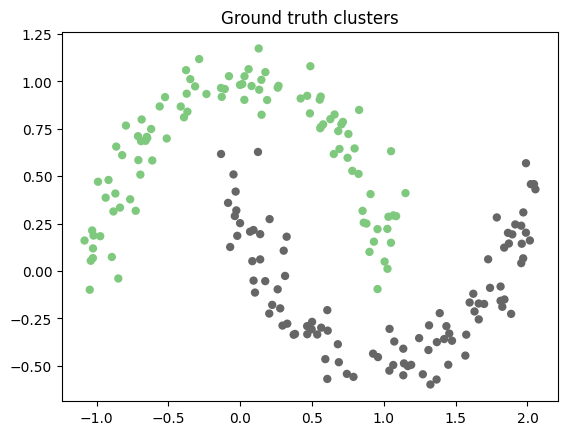

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Accent', linewidths=0)
plt.title('Ground truth clusters');

In [13]:
best = [0, 0]
# for theta in [1, 10, 20, 50, 100, 200]:
#     for m in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
from itertools import product 
nns = [15] # number of neighbours to consider for constructing the KNN graph (excluding the node itself)
thetas = [20]     # number of corrupted edges to remove/2 = theta
ms= [0.5] # [0.1, 0.2, 0.3, 0.4, 0.5]  # minimum  percentage of neighbours will be removed for each node (omega_i constraints)
for nn, theta, m in product(nns, thetas, ms): 
    try:
        #   print(f"*** theta: {theta}, m={m}")
        rsc = RSC(k=k, nn=nn, theta=theta, m=m, verbose=False)
        y_rsc = rsc.fit_predict(X)
        # print(y_rsc)
        nmi_rsc = nmi(y, y_rsc)

        sc = SpectralClustering(n_clusters=k, n_neighbors=nn+1, affinity='nearest_neighbors')  # nn+1 since they include self
        y_sc = sc.fit_predict(X)
        # print(y_sc)
        nmi_sc = nmi(y, y_sc)
    #         print('Vanilla Spectral Clustering NMI: {:.4f}\n Robust Spectral Clustering NMI: {:.4f}'.format(nmi(y, y_sc), nmi(y, y_rsc)))

        if nmi_rsc > best[0]:
            best = [nmi_rsc, nmi_sc, nn, theta, m, y_rsc, y_sc]
    except Exception as e:
        print(e, nn, theta)
print(best)

[0.9291252238549083, 0.5229779404495359, 15, 20, 0.5, array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

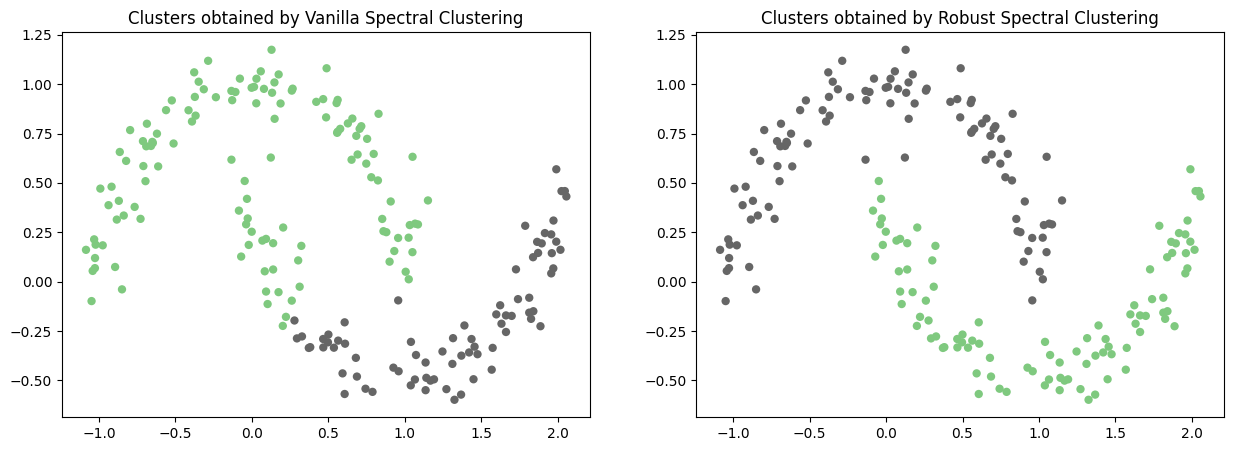

In [14]:
y_sc, y_rsc = best[-1], best[-2]
fig, ax = plt.subplots(1, 2, figsize=[15, 5])
ax[0].scatter(X[:, 0], X[:, 1], c=y_sc, cmap='Accent', linewidths=0)
ax[0].set_title('Clusters obtained by Vanilla Spectral Clustering')

ax[1].scatter(X[:, 0], X[:, 1], c=y_rsc, cmap='Accent', linewidths=0)
ax[1].set_title('Clusters obtained by Robust Spectral Clustering');

[-6.38353473e-17  1.46838500e-03]


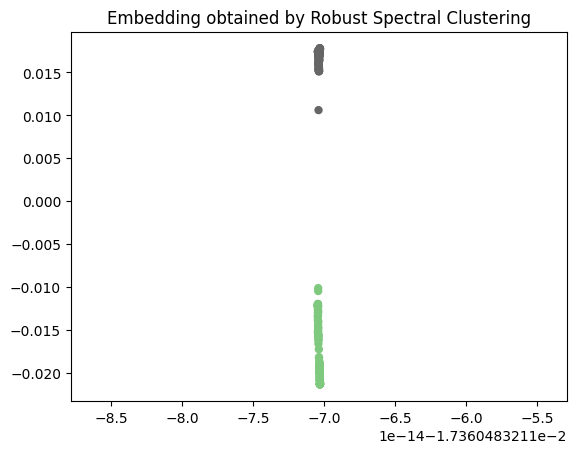

In [15]:
print(rsc.h)
plt.scatter(rsc.H[:, 0], rsc.H[:, 1], c=y_rsc,  cmap='Accent', linewidths=0)
plt.title('Embedding obtained by Robust Spectral Clustering');

In [16]:
rsc.H[:, 0]

array([-0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01736048,
       -0.01736048, -0.01736048, -0.01736048, -0.01736048, -0.01

In [17]:
rsc.H[:, 1]

array([ 0.01779074,  0.01779074,  0.01781005,  0.01779074,  0.01779876,
        0.01779074,  0.01779074,  0.01775596,  0.01768515,  0.01775462,
        0.01771383,  0.01779074,  0.01773196,  0.01775462,  0.01775462,
        0.01748989,  0.01775596,  0.01726899,  0.0174716 ,  0.01725464,
        0.01721529,  0.01717523,  0.01719256,  0.01714993,  0.01714993,
        0.01741416,  0.01715671,  0.01703024,  0.01679154,  0.01703024,
        0.01715901,  0.01703024,  0.01701709,  0.01704974,  0.01643976,
        0.01697433,  0.01697433,  0.01664911,  0.01565113,  0.01642069,
        0.01528929,  0.01520525,  0.01542049,  0.01514812,  0.01537153,
        0.01545289,  0.01510903,  0.01550193,  0.01531338,  0.01559447,
        0.01542261,  0.01523571,  0.01516975,  0.0155881 ,  0.01564004,
        0.01542261,  0.01607191,  0.01598075,  0.01568561,  0.01578158,
        0.0158967 ,  0.01628507,  0.01598075,  0.01598075,  0.01676989,
        0.01609916,  0.01684757,  0.01631897,  0.01654408,  0.01

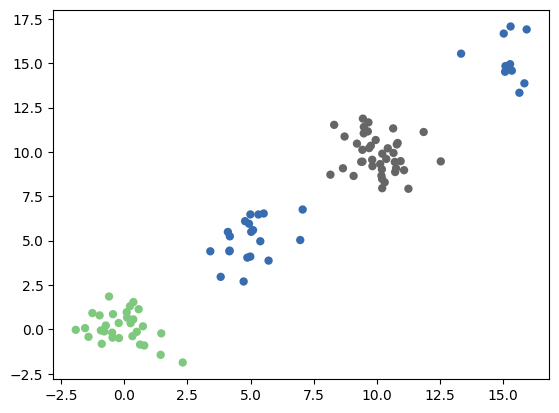

Using random walk based normalized Laplacian L_rw
[-1.9692668970744843e-16, -4.6827475335125147e-17, 1.4260209158910981e-16, 0.29688381167203576] [-4.6827475335125147e-17, 1.4260209158910981e-16, -1.9692668970744843e-16, 0.29688381167203576]
h[i] - h[i-1] diff：  [1.5009921437232328e-16, 1.8942956692423496e-16, 0.2968838116720356]
Iter: 0, prev_trace - trace: inf, Trace: -0.0000 h: [-1.96926690e-16 -4.68274753e-17]
[-1.5793577476324663e-16, 6.799034311174347e-17, 1.3917894817866948e-16, 0.29607865429626856] [6.799034311174347e-17, 1.3917894817866948e-16, -1.5793577476324663e-16, 0.29607865429626856]
h[i] - h[i-1] diff：  [2.2592611787499007e-16, 7.118860506692601e-17, 0.2960786542962684]
Iter: 1, prev_trace - trace: -1.538087333910704e-16, Trace: -0.0000 h: [-1.57935775e-16  6.79903431e-17]
[-1.57935775e-16  6.79903431e-17] 2


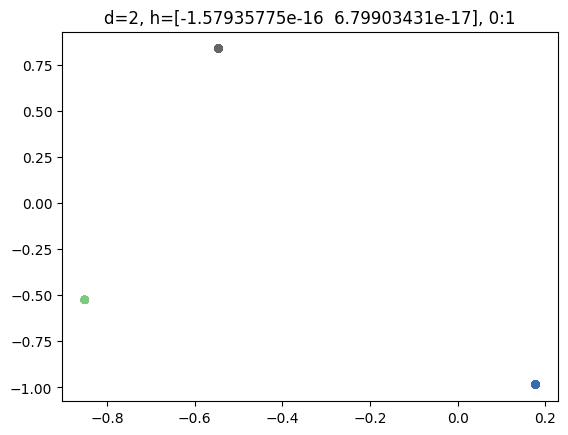

Using random walk based normalized Laplacian L_rw
[-1.9692668970744843e-16, -4.6827475335125147e-17, 1.4260209158910981e-16, 0.29688381167203576] [-4.6827475335125147e-17, 1.4260209158910981e-16, -1.9692668970744843e-16, 0.29688381167203576]
h[i] - h[i-1] diff：  [1.5009921437232328e-16, 1.8942956692423496e-16, 0.2968838116720356]
Iter: 0, prev_trace - trace: inf, Trace: -0.0000 h: [-1.96926690e-16 -4.68274753e-17]
[-2.3467310451118023e-16, -6.95101948546396e-17, 9.429118089239772e-17, 0.28731718758639707] [-6.95101948546396e-17, 9.429118089239772e-17, -2.3467310451118023e-16, 0.28731718758639707]
h[i] - h[i-1] diff：  [1.6516290965654064e-16, 1.6380137574703734e-16, 0.28731718758639696]
Iter: 1, prev_trace - trace: 6.042913432324627e-17, Trace: -0.0000 h: [-2.34673105e-16 -6.95101949e-17]
[-2.34673105e-16 -6.95101949e-17] 2


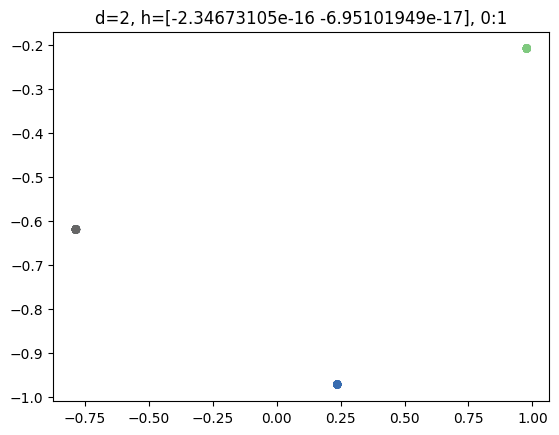

Using random walk based normalized Laplacian L_rw
[-1.9692668970744843e-16, -4.6827475335125147e-17, 1.4260209158910981e-16, 0.29688381167203576] [-4.6827475335125147e-17, 1.4260209158910981e-16, -1.9692668970744843e-16, 0.29688381167203576]
h[i] - h[i-1] diff：  [1.5009921437232328e-16, 1.8942956692423496e-16, 0.2968838116720356]
Iter: 0, prev_trace - trace: inf, Trace: -0.0000 h: [-1.96926690e-16 -4.68274753e-17]
[6.899189234504683e-18, 6.25785954974181e-17, 6.60939815964205e-17, 0.2904334292412668] [6.899189234504683e-18, 6.25785954974181e-17, 6.60939815964205e-17, 0.2904334292412668]
h[i] - h[i-1] diff：  [5.567940626291341e-17, 3.515386099002407e-18, 0.29043342924126675]
Iter: 1, prev_trace - trace: -3.1323194977449633e-16, Trace: 0.0000 h: [6.89918923e-18 6.25785955e-17]
[6.89918923e-18 6.25785955e-17] 2


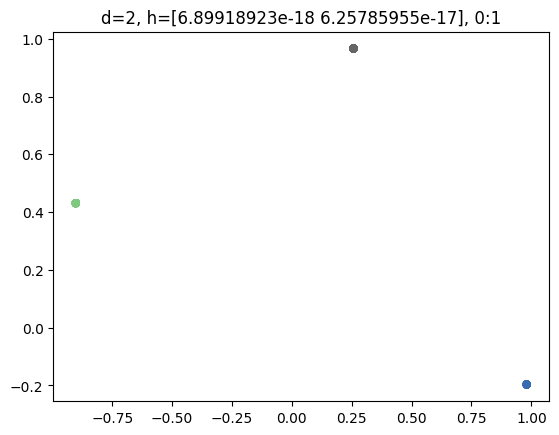

Using random walk based normalized Laplacian L_rw
[-1.9692668970744843e-16, -4.6827475335125147e-17, 1.4260209158910981e-16, 0.29688381167203576] [-4.6827475335125147e-17, 1.4260209158910981e-16, -1.9692668970744843e-16, 0.29688381167203576]
h[i] - h[i-1] diff：  [1.5009921437232328e-16, 1.8942956692423496e-16, 0.2968838116720356]
Iter: 0, prev_trace - trace: inf, Trace: -0.0000 h: [-1.96926690e-16 -4.68274753e-17]
[6.899189234504683e-18, 6.25785954974181e-17, 6.60939815964205e-17, 0.2904334292412668] [6.899189234504683e-18, 6.25785954974181e-17, 6.60939815964205e-17, 0.2904334292412668]
h[i] - h[i-1] diff：  [5.567940626291341e-17, 3.515386099002407e-18, 0.29043342924126675]
Iter: 1, prev_trace - trace: -3.1323194977449633e-16, Trace: 0.0000 h: [6.89918923e-18 6.25785955e-17]
[6.89918923e-18 6.25785955e-17] 2


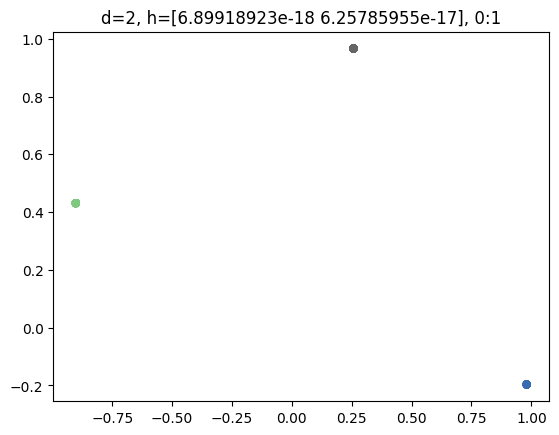

In [20]:
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding
from sklearn.metrics import silhouette_score
# Generate synthetic data with 3 clusters
np.random.seed(42)
data = np.random.randn(100, 10)
data[30:60] += 5
data[50:] += 10

y = [0]* 30 + [1]*30 + [2]*40
X = data
plt.scatter(X[:, 0], X[:, 1],c = y, cmap='Accent', linewidths=0)
plt.show() 

# Evaluate silhouette score for different embedding dimensions
# embedding_dimensions = range(2, 6)
silhouette_scores = []
ms = [0.1, 0.2, 0.4, 0.5]
for d in ms:
    # spectral = SpectralClustering(n_clusters=3, eigen_solver='arpack', affinity='nearest_neighbors', n_neighbors=10, n_components=d)
    # labels = spectral.fit_predict(data)
    # silhouette_scores.append(silhouette_score(data, labels))
    
    # connectivity = kneighbors_graph(
    #             X, n_neighbors=10, include_self=True, n_jobs=None
    #         )
    # affinity_matrix_ = 0.5 * (connectivity + connectivity.T)
    # 
    # maps = spectral_embedding(
    #     affinity_matrix_,
    #     n_components=d,
    #     eigen_solver=None,
    #     random_state=None,
    #     eigen_tol=0.0,
    #     norm_laplacian=True,
    #     drop_first=True,
    # )
    
    rsc = RSC(k=2, nn=15, theta=20, m=d,laplacian=1,  normalize=True, verbose=True, random_state=42)
    # y_rsc = rsc.fit_predict(X)
    Ag, Ac, H = rsc._RSC__latent_decomposition(data)
    # # Ag: similarity matrix of good points
    # # Ac: similarity matrix of corruption points
    # # A = Ag + Ac
    # rsc.Ag = Ag
    # rsc.Ac = Ac

    if rsc.normalize:
        rsc.H = H / np.linalg.norm(H, axis=1)[:, None]
    else:
        rsc.H = H

    projected_points = rsc.H
    print(rsc.h, rsc.k, flush=True)
    if len(rsc.h) >=2:
        
        for i in range(len(rsc.h)-1):
            plt.scatter(projected_points[:, i], projected_points[:, i+1], c=y, cmap='Accent', linewidths=0)
            plt.title(f'd=2, h={rsc.h}, {i}:{i+1}')
        plt.show() 

# # Plot silhouette scores
# plt.plot(embedding_dimensions, silhouette_scores, marker='o')
# plt.xlabel('Embedding Dimension')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score vs. Embedding Dimension')
# plt.show()
